<a href="https://colab.research.google.com/github/Aicoaching2025/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

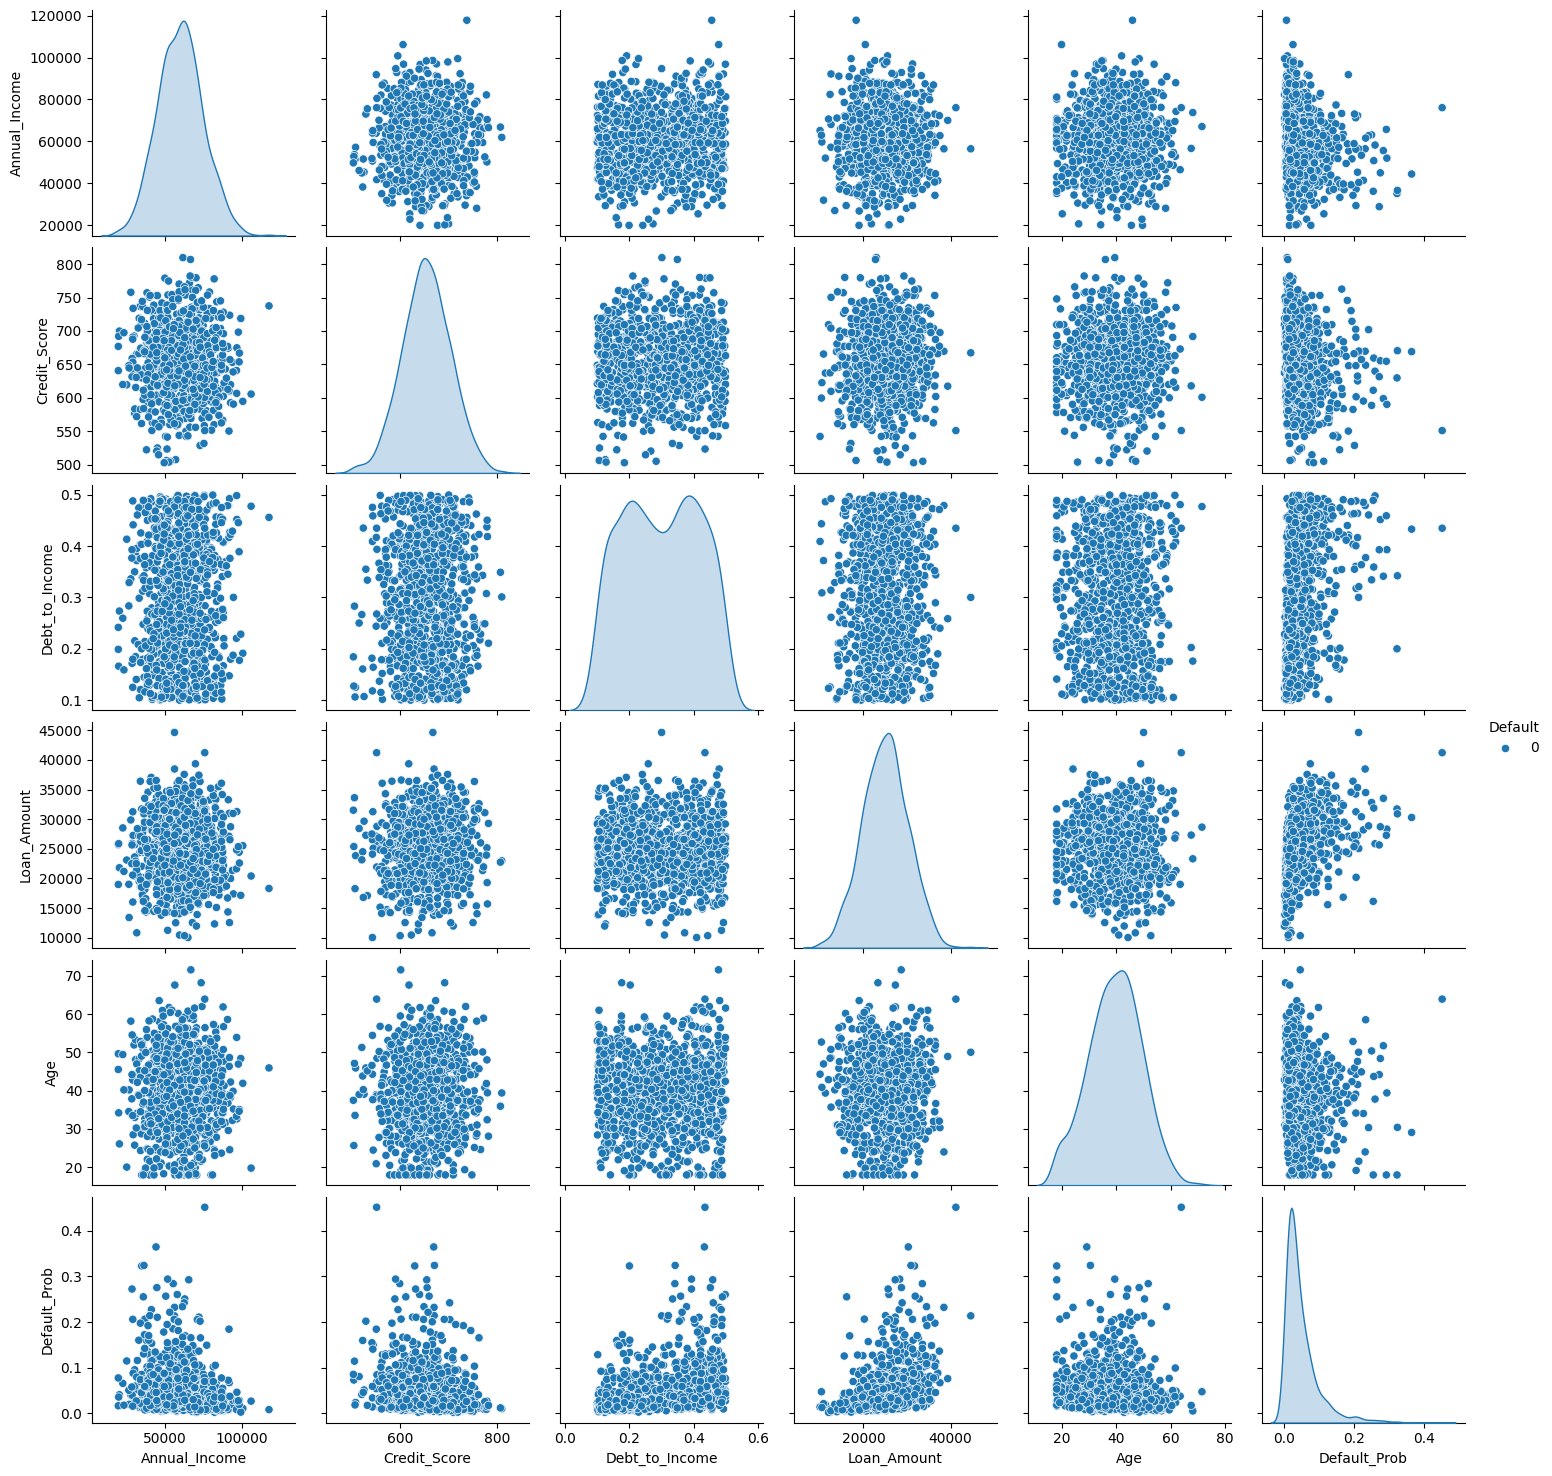

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)
n_samples = 1000

# Generate synthetic financial data with domain-specific features
annual_income = np.random.normal(60000, 15000, n_samples).clip(min=20000)
credit_score = np.random.normal(650, 50, n_samples).clip(300, 850)
debt_to_income = np.random.uniform(0.1, 0.5, n_samples)
loan_amount = np.random.normal(25000, 5000, n_samples).clip(min=5000)
age = np.random.normal(40, 10, n_samples).clip(min=18)
employment_status = np.random.choice(['Employed', 'Self-employed', 'Unemployed'],
                                     size=n_samples, p=[0.7, 0.2, 0.1])

# Create DataFrame
df = pd.DataFrame({
    'Annual_Income': annual_income,
    'Credit_Score': credit_score,
    'Debt_to_Income': debt_to_income,
    'Loan_Amount': loan_amount,
    'Age': age,
    'Employment_Status': employment_status
})

# Create binary target "Default"
# Using a logistic function to simulate default risk
logit = (
    -2
    - 0.00002 * df['Annual_Income']
    - 0.005 * df['Credit_Score']
    + 4.0 * df['Debt_to_Income']
    + 0.0001 * df['Loan_Amount']
    - 0.02 * df['Age']
)
employment_adjustment = df['Employment_Status'].map({
    'Employed': 0,
    'Self-employed': 0.5,
    'Unemployed': 1.5
})
logit += employment_adjustment
df['Default_Prob'] = 1 / (1 + np.exp(-logit))
df['Default'] = (df['Default_Prob'] > 0.5).astype(int)

# Exploratory Data Analysis (EDA)
# Pairplot to visualize relationships among features and target
sns.pairplot(df, hue='Default', diag_kind='kde')
plt.show()

# Feature Engineering
# Create a new feature: Financial Stress = (Loan_Amount / Annual_Income) * Debt_to_Income
df['Financial_Stress'] = (df['Loan_Amount'] / df['Annual_Income']) * df['Debt_to_Income']
# One-hot encode Employment_Status
df_encoded = pd.get_dummies(df, columns=['Employment_Status'], drop_first=True)

# Prepare data for modeling
features = [
    'Annual_Income', 'Credit_Score', 'Debt_to_Income',
    'Loan_Amount', 'Age', 'Financial_Stress',
    'Employment_Status_Self-employed', 'Employment_Status_Unemployed'
]
X = df_encoded[features]
y = df_encoded['Default']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Check the unique values of y_train
if len(np.unique(y_train)) < 2:
    print("Warning: y_train has only one unique class. Skipping model fitting.")
    # Optionally handle this situation, like changing the test_size or using a different solver
else:
    # Train logistic regression model with class weighting for imbalance
    # Change solver to 'lbfgs' and remove class_weight
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    # Predict and Evaluate
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve Visualization
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()